<a href="https://colab.research.google.com/github/schaftler/DESY_FS-TUXS_Project/blob/main/DESY_GS_Optimized_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
import numpy as np
from qutip import *
from numpy.linalg import multi_dot
import matplotlib.pyplot as plt

In [ ]:
#pip install qutip

# Initialize lists of pauli operators 

In [ ]:
def initialize(N):
    si = qeye(2)
    #sm = np.dot(zero,one.T);
    #sp = np.dot(one,zero.T);
    sm=sigmap() #Qutip uses inverse notation, please check the end of the notebook
    sp=sigmam()
    sz=sigmaz()
    sz_list = []
    sp_list = []
    sm_list = []
    spsm_list = [] 
    
    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)
        op_list[n]=sz
        sz_list.append(tensor(op_list))
        #Create lists of sp,sm operators for KroneckerProduct(Id2,Id2,...Sp,Id2, Sm) operation
        op_list[n] = sp
        sp_list.append(tensor(op_list))
        
        op_list[n] = Qobj(sm)
        sm_list.append(tensor(op_list))

        #Create a list of spsm operators like KroneckerProduct(Sp.Sm,Id2), yes there is
        op_list[n] = Qobj(np.dot(sp,sm))
        spsm_list.append(tensor(op_list))
        
    return sp_list,sm_list,spsm_list,sz_list

# Define interaction rates

In [ ]:
# Specify an argument such that it is easy to select between "Dicke","General",etc
def interaction_rates(N,general=False,dicke=False,simp=True):
        
    if simp==True:
        #When all interaction rates are equal
        gamma_i=np.ones(N) 
        gamma_j=np.ones(N)
        #For the Dicke case
    if dicke==True:
        gamma_i=np.asarray(0.5*np.ones(N))
        gamma_j=np.asarray(0.2*np.ones(N))
    #For generalized case. Initially using a set of random rates between (0,1), 
    #but can be done using interatomic distance dependence
    if general==True:
        gamma_i=np.random.random(N)
        gamma_j=np.random.random(N)
        
    return gamma_i,gamma_j

# Initialize the state for evaluation, here $|ee..\rangle \langle ee..|$

In [ ]:
def init_state(N):
    op_list = []
    for i in range(N):
        op_list.append(basis(2,1))  #Creating a list of states for excited atoms
    #op_list[1]=basis(2,0)
    ket = tensor(op_list) #Creating a total tensor product state for initally excited atoms
    state = ket2dm(ket) #Creating a density matrix for the initial state
    return state

# Calculate orthogonal vectors

In [ ]:
#Calculate orthogonal vectors
def ovec(state):
    temp=state
    if type(temp)==qutip.qobj.Qobj:
        temp = temp.full()       
    ovec=temp/np.sqrt(np.tensordot(temp,temp))
    return ovec

# Calculate absolute norm of residue


In [ ]:
#Calculate absolute norm of residue
def abs_norm(p):
    if type(p)==qutip.qobj.Qobj:
        p = p.full()       
    e=np.ndarray.flatten(p)
    for i in range(len(e)):
        temp = e[i]
        if temp < 0:
            e[i]=-1*temp
    res=np.real(sum(e))
    return res

In [ ]:
#Alternate function using inbuilt np.absolute()
def abs_norm(p):
    if type(p)==qutip.qobj.Qobj:
        p = p.full()       
    e=np.ndarray.flatten(p)
    res=np.real(sum(np.absolute(e)))
    return res

# Calculate residue

In [ ]:
#Calculating the residue
def fn(e,et,state):
    if type(state)==qutip.qobj.Qobj:
        state = state.full()  
    for i in range(len(et)):
        state = state-np.tensordot(state,et[i])*et[i]
    if abs_norm(state)==0:
        res=0.0
    else:
        ovec = state/np.sqrt(np.tensordot(state,state)) 
        e.append(state)
        et.append(ovec)
        res = abs_norm(state)
    state=(Qobj(state).unit()).full()
    #print('res=',res)
    #print('e=',e)
    #print('et=',et)
    return res,state

# Calculate lindbladian for given state, interaction rates

In [ ]:
def liouville_gen(N,state,et,e_lis,L_list=[],gamma_i=[],gamma_j=[],num=[],dicke=False,general=False,simp=False):
    if simp==True:
        gamma_i,gamma_j = interaction_rates(N)  #define interatcion rates depending on the model needed

    if dicke==True:
        gamma_i,gamma_j = interaction_rates(N,dicke=True)  #define interatcion rates depending on the model needed

    if general==True:
        gamma_i,gamma_j = interaction_rates(N,general=True)  #define interatcion rates depending on the model needed

    #gamma_i=[0.2,0.3,0.4]
    #gamma_j=[0.1,0.12,0.221]
    sp_list,sm_list,spsm_list,sz_list=initialize(N) #initialize all the operator lists
    L_list=[]
    L_list.append(state)

    
    L=[] #storing result of Lindbladian operation
    num_states=[np.count_nonzero(state)] #count states
    #L_list.append(state) #start with the initial state
    L_tot=0
  
    for i in range(N):
        for j in range(N):
            #Solve the Liouville
            if i == j:
                L.append(gamma_i[i]*(Qobj(multi_dot([sm_list[i],state,sp_list[i]])- 0.5*multi_dot([spsm_list[i],state]) - 0.5*multi_dot([state,spsm_list[i]]))))
                #L.append(0.6*(Qobj(multi_dot([sz_list[i],state,sz_list[i]])- 0.5*multi_dot([sz_list[i],sz_list[i],state]) - 0.5*multi_dot([state,sz_list[i],sz_list[i]]))))
            else:
                L.append(gamma_j[i]*(Qobj(multi_dot([sm_list[j],state,sp_list[i]])-0.5*multi_dot([sp_list[i],sm_list[j],state]) - 0.5*multi_dot([state,sp_list[i],sm_list[j]]))))
                #L.append(0.3*(Qobj(multi_dot([sz_list[j],state,sz_list[i]])- 0.5*multi_dot([sz_list[i],sz_list[i],state]) - 0.5*multi_dot([state,sz_list[i],sz_list[i]]))))

            #if i == j:
             #   L.append(gamma_i[i]*(Qobj(2*multi_dot([sm_list[i],state,sp_list[i]])- multi_dot([spsm_list[i],state]) - multi_dot([state,spsm_list[i]]))).unit())
            #else:
            #    L.append(gamma_j[i]*(Qobj(2*multi_dot([sm_list[j],state,sp_list[i]])-multi_dot([sp_list[i],sm_list[j],state]) - multi_dot([state,sp_list[i],sm_list[j]]))).unit())
    size=len(L)

    for n in range(size):
        L_tot=L_tot+L[n] #Summing all the terms in Lindbladian
    
    L_list.append(L_tot)
    num_states.append(np.count_nonzero(L_tot))
    size2=len(L_list)
    
    for m in range(0,size2):
        num_states.append(np.count_nonzero(L_list[m]))
        
    num.append(num_states[1])
    #np.real(np.asarray(L_list).full())

    res,state = fn(e_lis,et,L_tot)
    #np.set_printoptions(precision=3)
    
    #dim=to_super(Qobj(state))
    #residue can be used directly for next Lindbladian operation (orthogonal part) and normalize it!
    #Also keep max.inter. rate = 1
    #self-interactions (check literature)
    #setting precision: comparing norms of resulting state and residue n_state/n_norm~1e-9
    n_state = abs_norm(state)
    precision=res/abs_norm(state)
    if precision<1e-5:
        res = np.round(res,4)

    if res!=0.0:
        state = state
        #evec = ovec(state)
        #et_lis.append(evec)
        #et.append(evec)
        if simp==True:
            liouville_gen(N,state,et,e_lis,num,simp=True)
        if dicke==True:
            liouville_gen(N,state,et,e_lis,num,dicke=True)
        if general==True:
            liouville_gen(N,state,et,e_lis,num,general=True)
    else:
        #print("total no. of states =", np.count_nonzero(L_tot))
        print("All states found!")
    
    print("state=",L_tot)
    print("res=",res)
    print("number of states involved = ",len(num)+1)
    print("states=",num)
    #print('dimns=',dim)
    #print('inner =',inner) 
    #print('et=',et)
    return 
  



# All pieces together

In [ ]:

def main(N,num=[],et=[],e_lis=[],dicke=False,general=False,simp=False):
    initialize(N)
    state=init_state(N)
   
    
    e_lis.append(state)
    evec = ovec(state)
    #et_lis.append(evec)
    et.append(evec)
    
    if simp==True:
        liouville_gen(N,state,et,e_lis,L_list=[],gamma_i=[],gamma_j=[],num=[],simp=True)
        
    if dicke==True:
        liouville_gen(N,state,et,e_lis,L_list=[],gamma_i=[],gamma_j=[],num=[],dicke=True)
        
    if general==True:
        liouville_gen(N,state,et,e_lis,L_list=[],gamma_i=[],gamma_j=[],num=[],general=True)

# Execute

In [ ]:
main(5,general=True)

All states found!
state= Quantum object: dims = [[32], [32]], shape = (32, 32), type = oper, isherm = False
Qobj data =
[[-0.36343493  0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.15002449 -0.02574267 ...  0.          0.
   0.        ]
 [ 0.          0.18665689  0.03577386 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.03555549 -0.02358498
   0.        ]
 [ 0.          0.          0.         ... -0.04252588 -0.02272093
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
res= 0.0
number of states involved =  254
states= [125, 225, 250, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251,

# Results

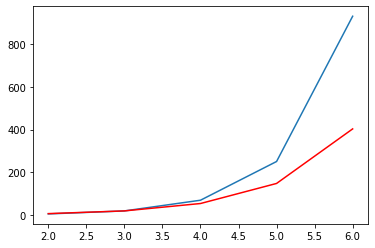

In [ ]:
#Simple case (all_gamma==1)
n_atoms = [2,3,4,5,6,7]
states = [3,4,5,6,7,8] 

#Dicke Case (only collective)
n_atoms = [2,3,4,5,6,7]
states = [3,5,7,10,15,18]

#Earlier, when the self interaction rate is low as compared to interatomic int. rate by 1/10 times, the discrepancy in two atoms arises,
#but if we keep it to be \gamma_{ii}=0.1,\gamma_{ij}=0.5, the # states for 3 atoms is fixed but not for 6 atoms.
#but as the rate is fixed to  \gamma_{ii}=0.2,\gamma_{ij}=0.5,, the original states are retained.
#states = [4,6,9,12,16,20]


#Dicke Case (local+collective)
n_atoms = [2,3,4,5,6,7]
states = [3,6,9,12,15,20]

#Case with local dephasing, etc.
n_atoms = [2,3,4,5,6,7]
states = [4,6,9,12,16,20]

#Case with collective dephasing, etc.
n_atoms = [2,3,4,5,6,7]
states = [4,6,9,12,16,20]

#Case with (local+collective) dephasing, etc.
n_atoms = [2,3,4,5,6,7]
states = [4,6,9,12,16,20]

#General Case ()
n_atoms = [2,3,4,5,6]
states = [6,20,70,251,930]#excluding the excited state

plt.plot(n_atoms,states)
plt.plot(n_atoms,np.exp(n_atoms),'r')

In [ ]:
to_super(Qobj(init_state(4)))



Quantum object: dims = [[[2, 2, 2, 2], [2, 2, 2, 2]], [[2, 2, 2, 2], [2, 2, 2, 2]]], shape = (256, 256), type = super, isherm = True
Qobj data =
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]

# Code Structure 

### 1. In the main(*args) function, specify the $\textbf{N}:$ no. of atoms, specify the kind of model that is to be evaluated, ex. for dicke case, just set, $\texttt{dicke=True}$, empty lists for counting the states, and storing the orthogonalized vectors. 

### 2. The main function then initializes the pauli operators required for Lindblad calculation for given $\texttt{N}$, using the $\texttt{initialize(N)}$ function.

### 3. The $\texttt{init_state(N)}$ function is used to generate the inital state of the system.

### 4. The $\texttt{e_lis=[]}$ stores the residue at each step, it starts with storing the inital state.

### 5. $\texttt{et}$ stores the orthogonal vectors calculated at each step using the $\texttt{ovec(state)}$ function. Orthogonal vector corresponding to initial state is stored first.

### 6. Depending upon the argument provided for the type of model, (ex. for Dicke case, set $\texttt{dicke=True}$), it evaluates the all the involved states until the norm of residue is $0.0$ using the function $\texttt{liouville_gen()}$


# Dicke Model 
Ignoring the local processes and check the evolution of number of states.
$\Gamma_{ii}=\gamma_{c}=0$, and $\gamma_{ij}=\gamma$

# Generating Interaction Rates for general case
1. Line Shape:

If only nearest neighbor interactions are considered, then $\gamma_{i,j}, |i-j|=1$

In [ ]:
N=4
g_self=[]
g_int=[]
g_s=0.5
g_i=0.2
for i in range(N):
  for j in range(N):
    if i==j:
      g_self.append(g_s)
    else:
      if np.abs(i-j)==1:
        g_int.append(g_i)
      else:
        g_int.append(0)
print(g_self,g_int)


[0.5, 0.5, 0.5, 0.5] [0.2, 0, 0, 0.2, 0.2, 0, 0, 0.2, 0.2, 0, 0, 0.2]


# For long range interactions the interaction rate should drop off somehow

## 2. Partially filled square
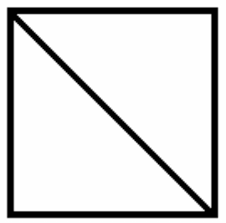


In [ ]:
N=4
if N%2==0:
  a=np.zeros(N)
  sq=a@a.T
sq

0.0